In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.strategies import *
import matplotlib.pyplot as plt
import pandas as pd
import time

In [15]:
torch.cuda.device_count()

4

In [16]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40338MB, multi_processor_count=108)

In [17]:
class CIFAR10ResNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, model_parallel=False):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet18(num_classes=10)
        self.learning_rate = learning_rate
        self.validation_start_time = None  # To track time for validation
        self.model_parallel = model_parallel

        if self.model_parallel:
            # Split the model into two parts, but don't move to GPUs manually
            self.model_part1 = torch.nn.Sequential(
                self.model.conv1, self.model.bn1, self.model.relu, self.model.maxpool,
                self.model.layer1, self.model.layer2, self.model.layer3
            )

            self.model_part2 = torch.nn.Sequential(
                self.model.layer4, self.model.avgpool
            )

    def forward(self, x):
        if self.model_parallel:
            # Forward pass split between two model parts (device placement will be handled by Lightning)
            x = self.model_part1(x)  # First part of the model
            x = self.model_part2(x)  # Second part of the model
            x = torch.flatten(x, 1)
            x = self.model.fc(x)
            return x
        else:
            return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

    def on_validation_epoch_start(self):
        self.validation_start_time = time.time()

    def on_validation_epoch_end(self):
        elapsed_time = time.time() - self.validation_start_time
        self.log('val_time', elapsed_time, prog_bar=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [18]:
# Function to train with 1 or 2 GPUs in model parallel and log metrics
def train_model(gpu_count, model_parallel, log_name):
    # Data Preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    dataset = CIFAR10(root='data', train=True, download=True, transform=transform)
    train_data, val_data = random_split(dataset, [45000, 5000])
    train_loader = DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, num_workers=4, shuffle=False)

    # Logger and checkpoint
    csv_logger = CSVLogger("logs", name=log_name)
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)
    
    # For DDP (Distributed Data Parallel) strategy which handles multi-GPU training, including model parallelism
    # (as parametrized by the lightning module's initialization
    strategy = "fsdp" if gpu_count > 1 else "auto"

    # Model Training
    model = CIFAR10ResNet(model_parallel=model_parallel)
    trainer = Trainer(
        max_epochs=20, 
        accelerator="gpu", 
        devices=gpu_count,  # Set number of GPUs
        strategy=strategy,  # Use DDP if > 1 GPU
        logger=csv_logger, 
        callbacks=[checkpoint_callback]
    )
    trainer.fit(model, train_loader, val_loader)

    # Return CSV log path for further analysis
    return csv_logger.experiment.metrics_file_path

Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type       | Params
-------------------------------------------
0 | model       | ResNet     | 11.2 M
1 | model_part1 | Sequential | 2.8 M 
2 | model_part2 | Sequential | 8.4 M 
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


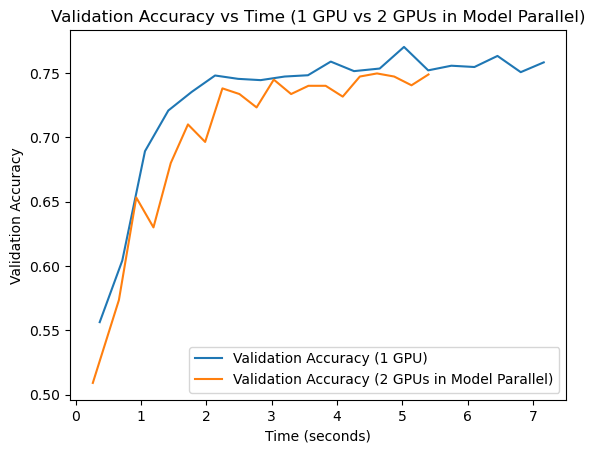

In [19]:
# Train using 1 GPU (no model parallelism)
log_file_1_gpu = train_model(gpu_count=1, model_parallel=False, log_name="cifar10_resnet18_1_gpu")

# Train using 2 GPUs with model parallelism
log_file_2_gpu = train_model(gpu_count=2, model_parallel=True, log_name="cifar10_resnet18_2_gpu")

# Load data from log files
data_1_gpu = pd.read_csv(log_file_1_gpu).dropna(subset=['val_acc'])
data_2_gpu = pd.read_csv(log_file_2_gpu).dropna(subset=['val_acc'])

# Plot Validation Accuracy vs Time for 1 and 2 GPUs in model parallel
plt.figure()

# Cumulative validation times for 1 GPU
val_times_1_gpu = data_1_gpu['val_time'].cumsum()
plt.plot(val_times_1_gpu, data_1_gpu['val_acc'], label='Validation Accuracy (1 GPU)')

# Cumulative validation times for 2 GPUs in model parallel
val_times_2_gpu = data_2_gpu['val_time'].cumsum()
plt.plot(val_times_2_gpu, data_2_gpu['val_acc'], label='Validation Accuracy (2 GPUs in Model Parallel)')

plt.xlabel('Time (seconds)')
plt.ylabel('Validation Accuracy')
plt.legend(loc='best')
plt.title('Validation Accuracy vs Time (1 GPU vs 2 GPUs in Model Parallel)')
plt.savefig('val_acc_model_parallel.png')
plt.show()